In [1]:
import pandas as pd
import json
%matplotlib inline

with open("../plain_prov/floydwarshall.json", "r") as f:
    prov = json.load(f)
with open("../prov_dictionary/floydwarshall.json", "r") as f:
    prov_dictionary = json.load(f)
with open("../mutable_prov/floydwarshall.json", "r") as f:
    mutable_prov = json.load(f)
    


In [2]:
dict(mutable_prov)

{'accessed': 47,
 'accessedPart': 134,
 'activity': 211,
 'defined': 35,
 'derivedByInsertion': 8,
 'entity': 216,
 'used': 336,
 'value': 41,
 'wasDerivedFrom': 101,
 'wasGeneratedBy': 210}

In [3]:

order = [
    'approach',
    'entity', 'activity', 'value', 
    'used', 'wasDerivedFrom', 'wasGeneratedBy',
    'hadMember', 'derivedByInsertionFrom',
    'accessedPart', 'accessed', 
    'defined', 'wasDefinedBy', 'derivedByInsertion'
]

In [4]:
df = pd.DataFrame([
    dict(**{'approach': 'PROV'}, **dict(prov)),
    dict(**{'approach': 'PROV-Dictionary'}, **dict(prov_dictionary)),
    dict(**{'approach': 'Mutable-PROV'}, **dict(mutable_prov))
], columns=order)

df[order[1:]] = df[order[1:]].fillna(0.0).astype(int)
df

,approach,entity,activity,value,used,wasDerivedFrom,wasGeneratedBy,hadMember,derivedByInsertionFrom,accessedPart,accessed,defined,derivedByInsertion
0,PROV,354,212,0,602,352,346,177,0,0,0,0,0
1,PROV-Dictionary,276,212,0,491,244,235,0,45,0,0,0,0
2,Mutable-PROV,216,211,41,336,101,210,0,0,134,47,35,8


In [5]:
fmt = ['---' for i in range(len(df.columns))]
df_fmt = pd.DataFrame([fmt], columns=df.columns)
df_formatted = pd.concat([df_fmt, df])
df_formatted.columns = [
    'Approach',
    'entity', 'activity', 'value', 
    'used', 'was<br>Derived<br>From', 'was<br>Generated<br>By',
    'had<br>Member', 'derived<br>By<br>Insertion<br>From',
    'accessed<br>Part', 'accessed', 
    'defined', 'was<br>Defined<br>By', 'derived<br>By<br>Insertion'
]
print(df_formatted.to_csv(sep="|", index=False))
    
    

Approach|entity|activity|value|used|was<br>Derived<br>From|was<br>Generated<br>By|had<br>Member|derived<br>By<br>Insertion<br>From|accessed<br>Part|accessed|defined|derived<br>By<br>Insertion
---|---|---|---|---|---|---|---|---|---|---|---|---
PROV|354|212|0|602|352|346|177|0|0|0|0|0
PROV-Dictionary|276|212|0|491|244|235|0|45|0|0|0|0
Mutable-PROV|216|211|41|336|101|210|0|0|134|47|35|8



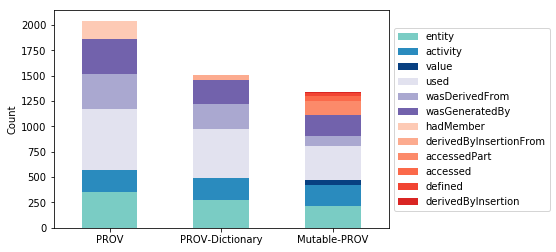

In [6]:
import matplotlib.pyplot as plt
import numpy as np

parts = len(order) - 1

colors1 = plt.cm.GnBu(np.linspace(0.5, 1, 3))
colors2 = plt.cm.Purples(np.linspace(0.2, 0.7, 3))
colors3 = plt.cm.Reds(np.linspace(0.2, 0.7, parts - 3 - 3))


# combine them and build a new colormap
colors = np.vstack((colors1, colors2, colors3))
#colors = plt.cm.GnBu(np.linspace(0, 1, 3))


gdf = df.set_index(["approach"])
f = plt.figure()
ax = f.gca()
gdf.plot(kind='bar', stacked=True, ax=ax, color=colors)
lgd = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("")
ax.set_ylabel("Count")
plt.xticks(rotation=0)
plt.savefig("../graphs/comparison.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../graphs/comparison.svg", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig("../graphs/comparison.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')